In [1]:
import torch
import networkx as nx

from dgl.data import MiniGCDataset, QM9Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from collections import Counter
from pprint import pprint

from auxiliary import Datasets
from auxiliary.GNNModels import GNNInvariant, GNNEquivariant2D

# Synthetic Dataset

The [MiniGC-dataset](https://docs.dgl.ai/generated/dgl.data.MiniGCDataset.html#dgl.data.MiniGCDataset) - obtained through the Deep Graph Library (DGL) - is a synthetic dataset of graphs. The dataset consists of 8 graph-types:

1. `cycle graph`
2. `star graph`
3. `wheel graph`
4. `lollipop graph`
5. `hypercube graph`
6. `grid graph`
7. `clique graph`
8. `circular ladder graph`

, that are created from user-defined input parameters determining the number of graphs and the range of their sizes.

## Creating a synthetic dataset

For creating a synthetic dataset like this, the input parameters must be specified.

In [2]:
num_graphs = 24
min_num_v = 4
max_num_v = 10
seed = 42

data = MiniGCDataset(num_graphs, min_num_v, max_num_v, seed=seed)

classNames = {0: 'cycle graph', 1: 'star graph', 2: 'wheel graph',
              3: 'lollipop graph', 4: 'hypercube graph', 5: 'grid graph',
              6: 'clique graph', 7: 'circular ladder graph'}

Let's briefly investigate the distribution across the categories.

In [3]:
dist_ = Counter([dat_[1].item() for dat_ in data])
print(f"{'-'*35}\n  Distribution across graph types\n{'-'*35}")
for graph_type, num_ in dist_.items():
    print(f"Count = {num_} \t({classNames[graph_type]})")

-----------------------------------
  Distribution across graph types
-----------------------------------
Count = 3 	(cycle graph)
Count = 3 	(star graph)
Count = 3 	(wheel graph)
Count = 3 	(lollipop graph)
Count = 3 	(hypercube graph)
Count = 3 	(grid graph)
Count = 3 	(clique graph)
Count = 3 	(circular ladder graph)


## Visualizing the dataset

The nodes and edges of each graph can be accessed through `networkx`. As is seen below, the various graph types are visualized using the function `nx.spring_layout` as a proxy for the node coordinates, which will be needed later on **(BE AWARE THAT THIS IS PROBABLY NOT A VALID WAY TO DO IT AS THE GRAPHS SEEM TO BE WEIRDLY ORIENTED IN SOME CASES)**.

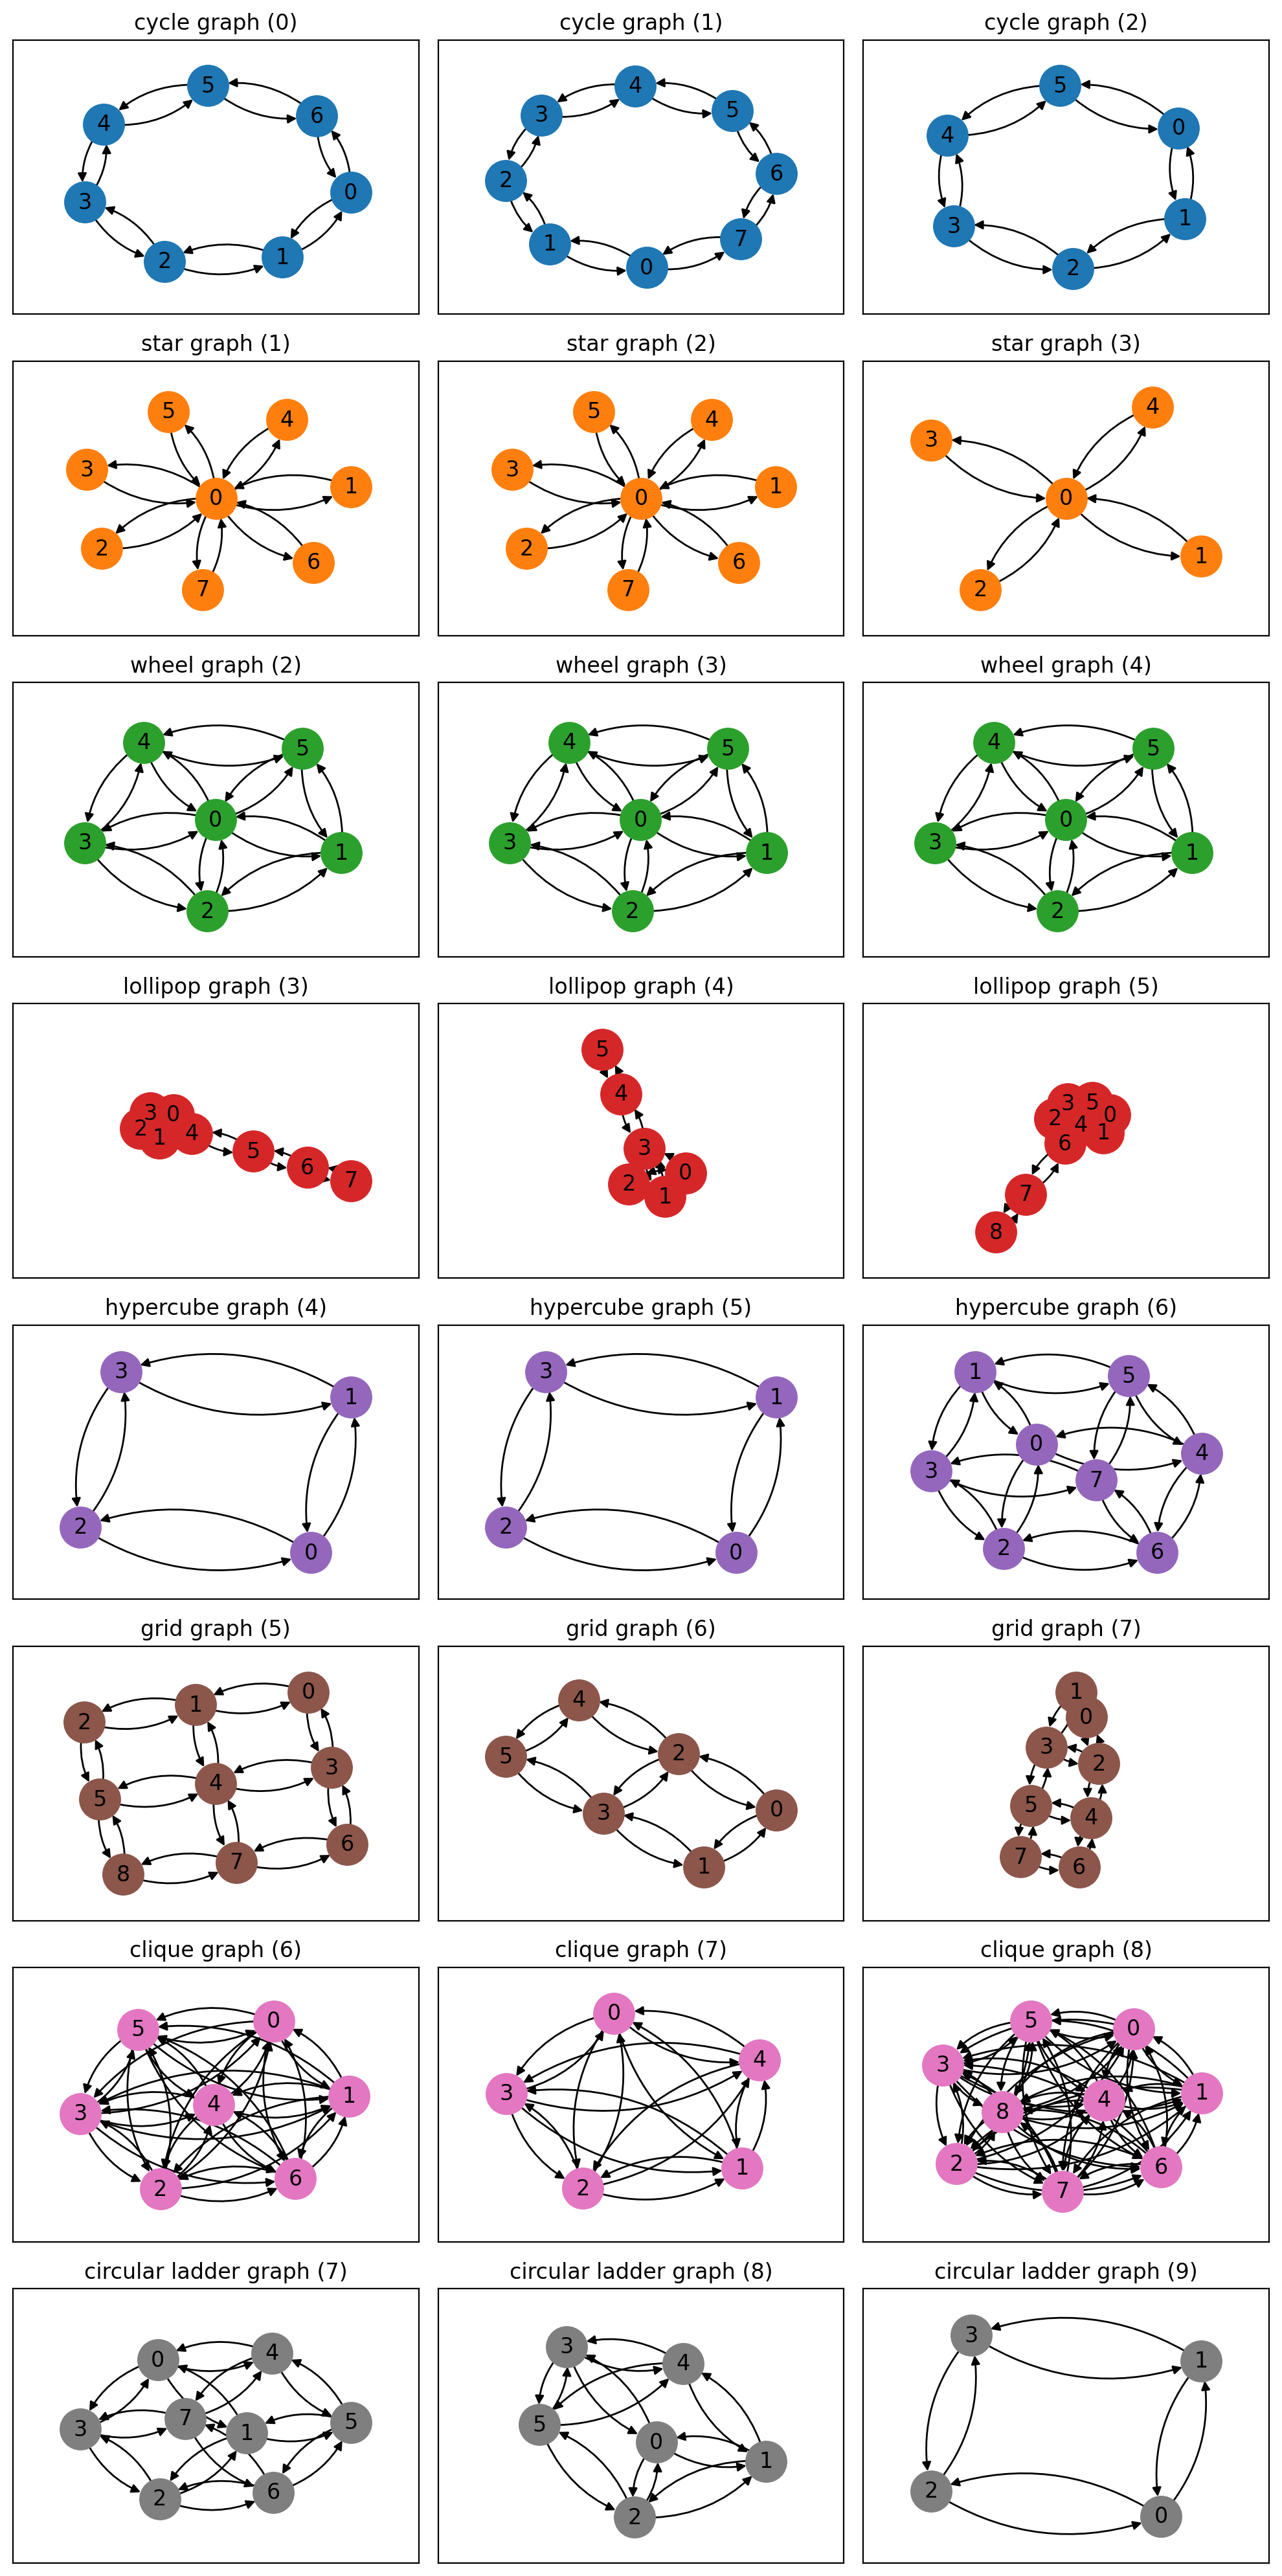

In [4]:
# Setup figure
plot_idx = 0
nrows, ncols = num_graphs // min(dist_.values()), min(dist_.values())
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 20), dpi=200) 

# Plot graphs
for i in range(nrows):
    for j in range(ncols):
        
        # Access graph-element
        g, label = data[plot_idx]

        # Construct networkx object
        G = nx.DiGraph(g.to_networkx())
        G.remove_edges_from(nx.selfloop_edges(G))

        # Draw graph
        axs[i, j].axis([-1.5, 1.5, -1.5, 1.5])
        axs[i, j].set_title(f"{classNames[label.item()]} ({i+j})")
        pos = nx.spring_layout(G, seed=seed)
        nx.draw_networkx(G, pos=pos, ax=axs[i, j], node_size=500, node_color=f'C{label.item()}', connectionstyle='arc3,rad=.25')
        
        # Update index
        plot_idx += 1
        
plt.tight_layout()

## Constructing a GraphDataset-object

Instead of accessing the graphs from the `networkx`-structure, it will be computationally smarter to load the data as a `GraphDataset`-object - both in terms of efficiency and for being rotating and translating graphs in order to evaluate in- and equivariant Graph Neural Networks. 

An example of this is seen below, where the synthetically created graphs have been tranlated towards the right while being rotated as well. Remark, that the `GraphDataset`-object ensures that information about all nodes is available.

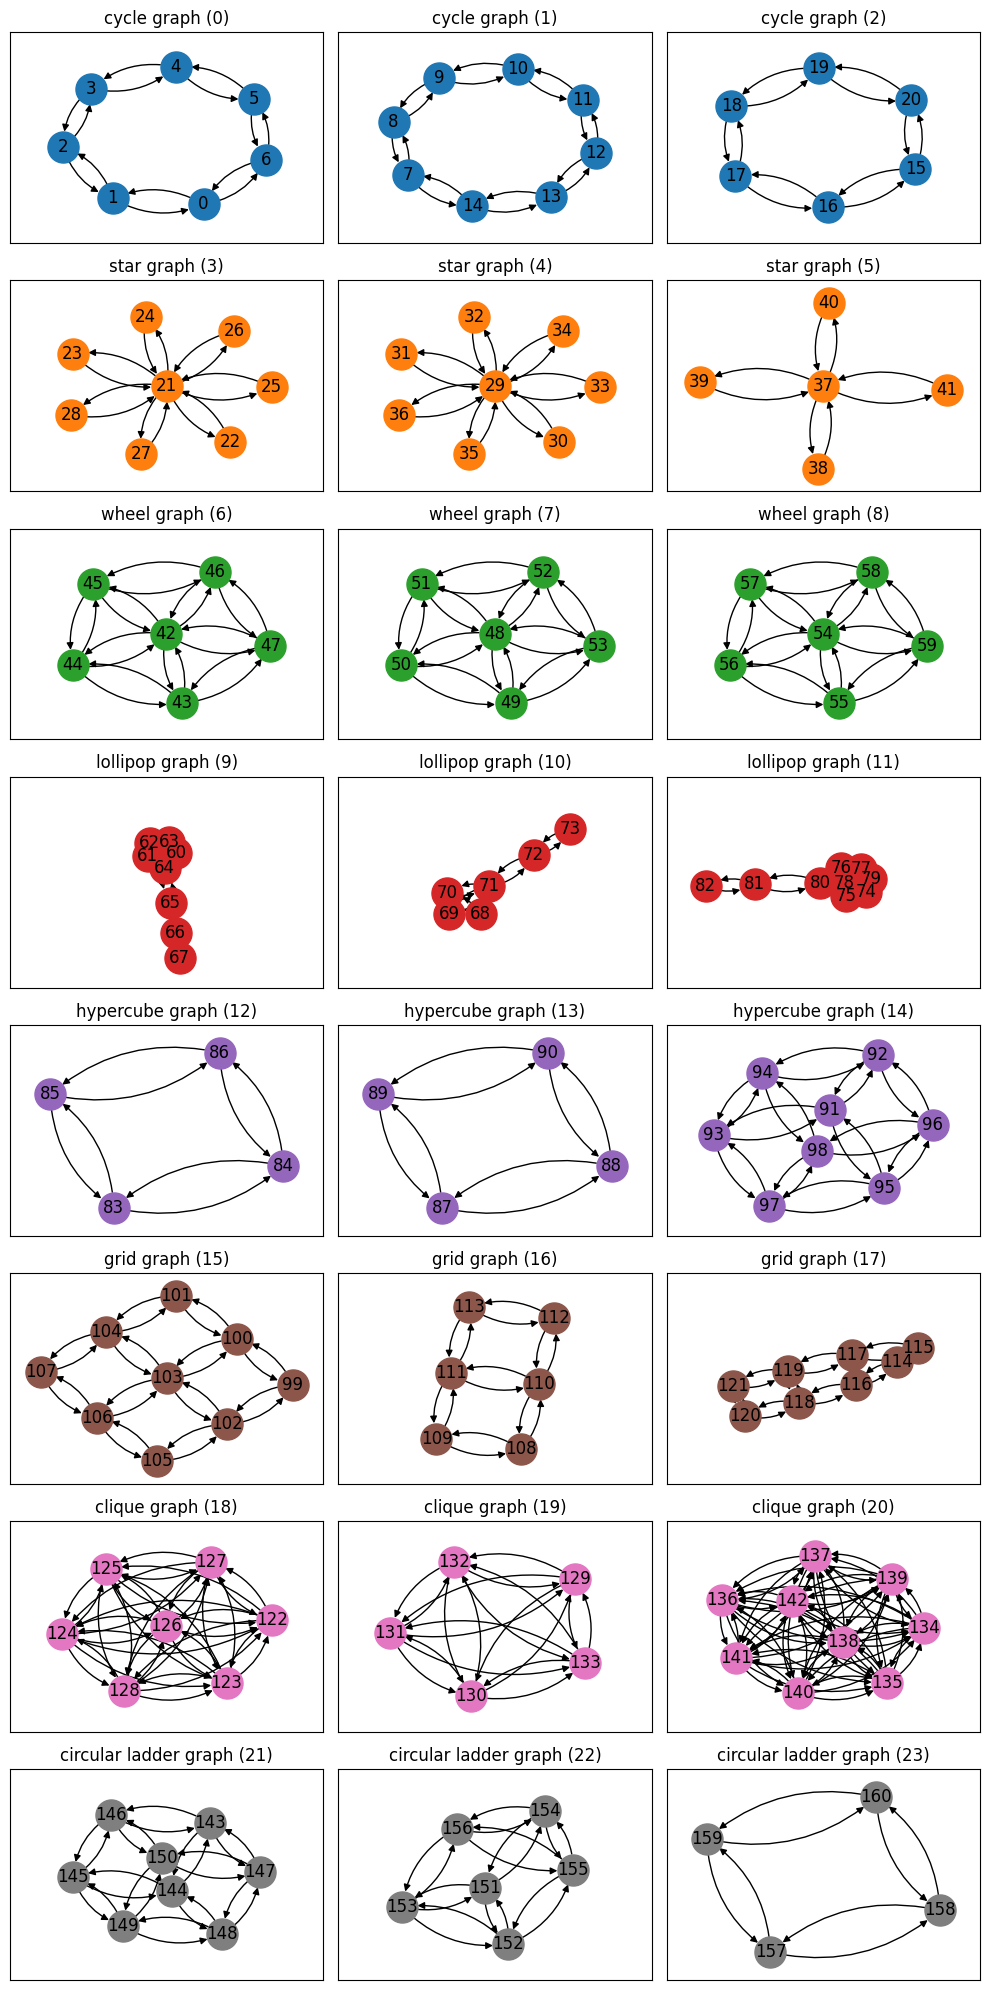

In [5]:
# Create dataset, center and rotate
data = Datasets.SyntheticData(24, 4, 10)
data.center().rotate(angle=np.pi/3)
#data.node_coordinates = data.node_coordinates + torch.tensor([1, 0])

# Plot the dataset
dist_min = min(dist_.values())
nrows, ncols = num_graphs // dist_min, dist_min

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 20))
for i in range(data.num_graphs):
    
    axs[i // dist_min, i % dist_min].axis([-1.5, 1.5, -1.5, 1.5])
    axs[i // dist_min, i % dist_min].set_title(f"{data.graph_labels[i]} ({i})")
    
    edges = data.edge_list[data.edge_graph_index == i].tolist()
    nodes = np.arange(data.num_nodes)[data.node_graph_index == i]
    
    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = dict(zip(nodes, data.node_coordinates[nodes].tolist()))
    nx.draw_networkx(G, pos=pos, ax=axs[i // dist_min, i % dist_min], node_size=500, node_color=f'C{i//dist_min}', connectionstyle='arc3,rad=.25')

plt.tight_layout()

## Train Equivariant GNN

The data above can be used to train an equivariant GNN which is aware of translations and rotations of graphs. 

In [6]:
# Network, loss function, and optimizer
net = GNNEquivariant2D(output_dim=data.numClasses, state_dim = 10)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

epochs = 1000
lss = np.zeros(epochs)
acc = np.zeros(epochs)

with trange(epochs) as t:
    for epoch in t:
        optimizer.zero_grad()
        output = net(data)
        loss = loss_function(output, data.graph_list)
        loss.backward()
        optimizer.step()
        
        accuracy = (torch.argmax(output, 1) == data.graph_list).sum() / data.num_graphs
        t.set_description_str(\
             f'Loss: {loss.detach().numpy():.3f}, \
               Accuracy: {accuracy*100:.0f}%, Progress')
        
        lss[epoch] = loss
        acc[epoch] = accuracy


  0%|          | 0/1000 [00:00<?, ?it/s]

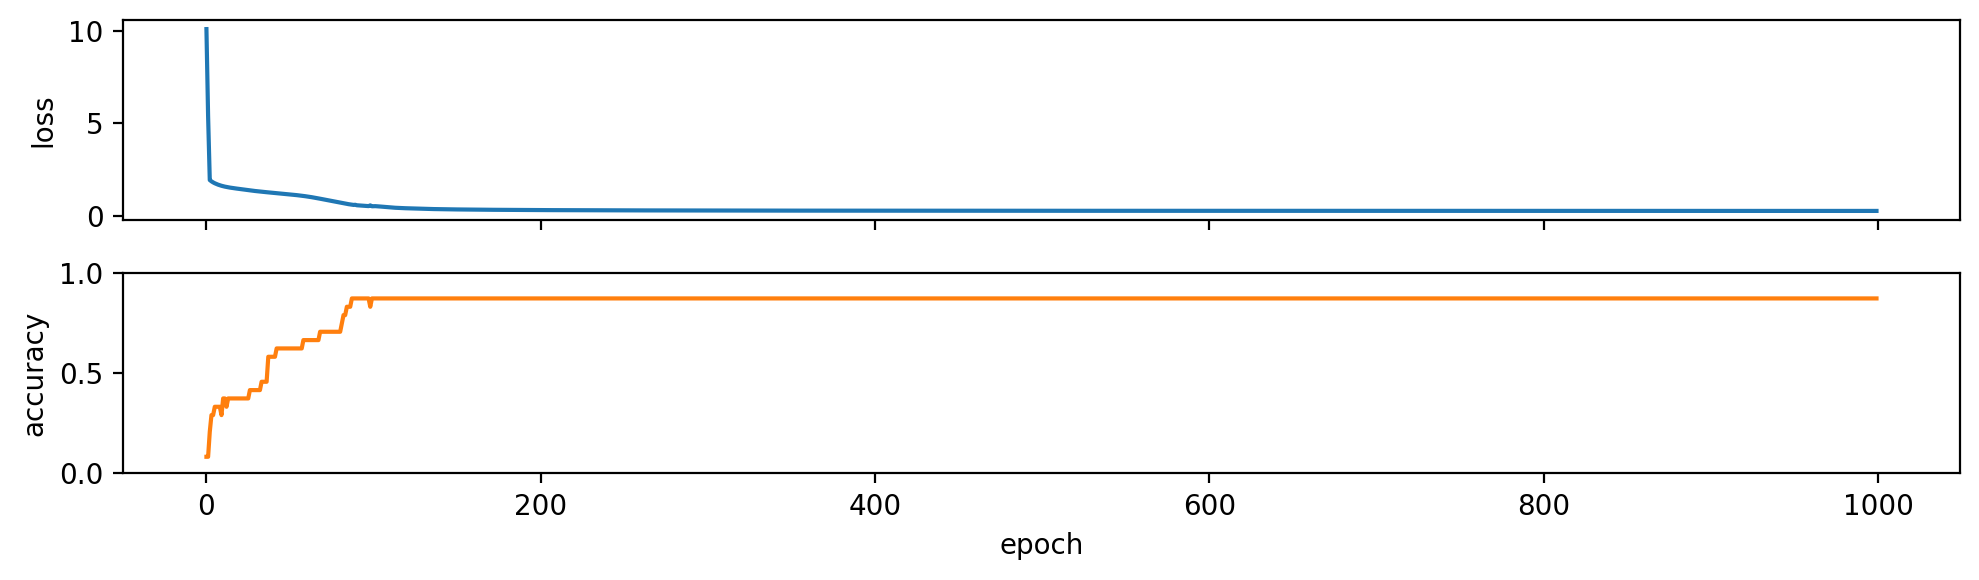

In [7]:
fig, ax = plt.subplots(2, 1, figsize=((10, 3)), sharex=True, dpi=200)
ax[0].plot(np.arange(epochs), lss, color='C0')
ax[1].plot(np.arange(epochs), acc, color='C1')

ax[0].set_ylabel("loss")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel('epoch')

ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

Looking further into probabilities of the predicted class of each graph might be insightful. Similarly, looking at the feature vectors for each graph.

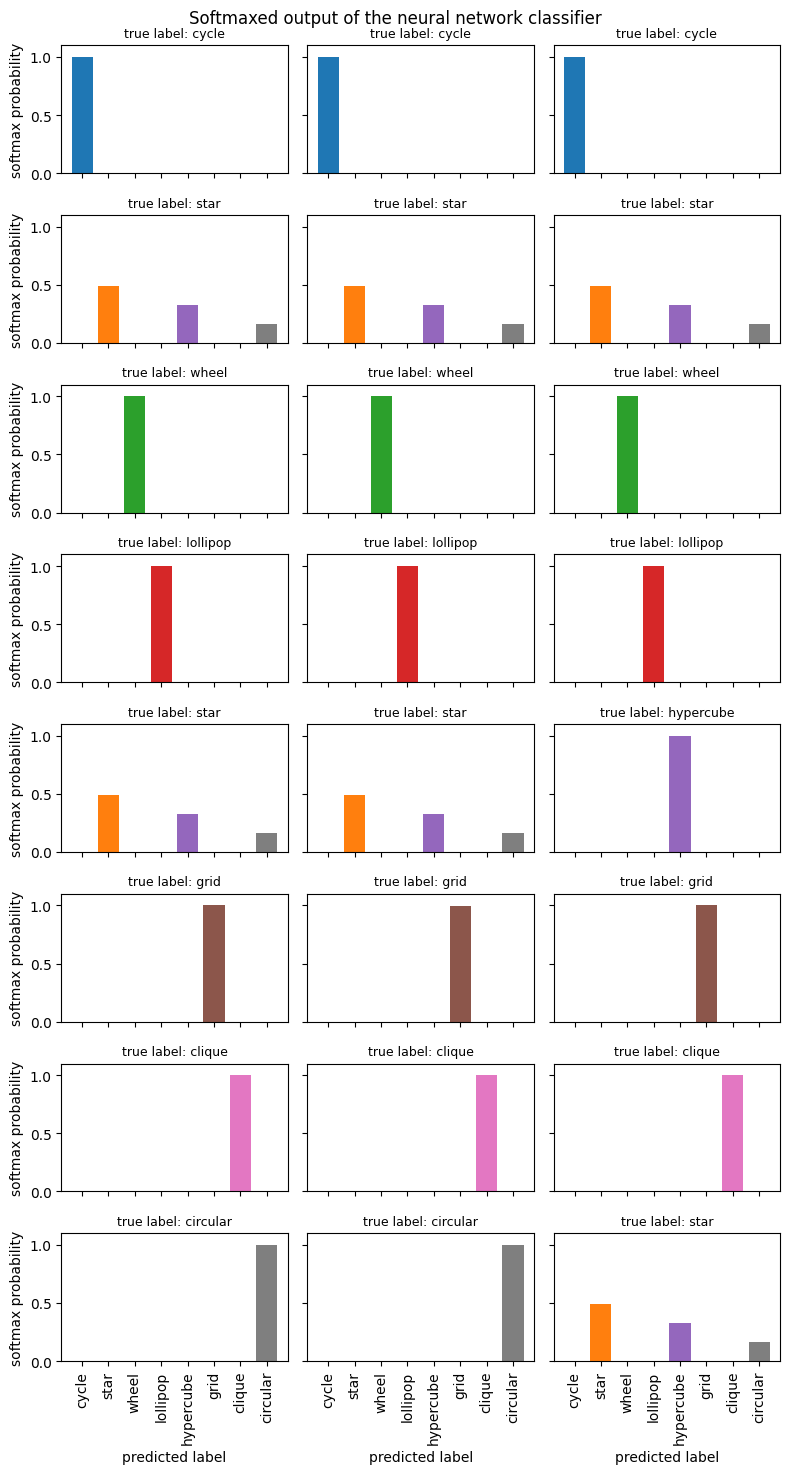

In [8]:
fig, axs = plt.subplots(nrows, ncols, figsize=((8, 15)), sharex=True, sharey=True)
fig.suptitle('Softmax''ed output of the neural network classifier')
for i in range(data.num_graphs):
    output_probs = torch.nn.functional.softmax(output[i], dim=0)
    axs[i // dist_min, i % dist_min].bar(range(data.numClasses), output_probs.tolist(), color=[f"C{i}" for i in range(data.numClasses)])
    axs[i // dist_min, i % dist_min].set_ylim([0, 1.1])
    
    # Labels
    xs, labels = [ls[0] for ls in zip(zip(*data.classNames.items()))]
    axs[i // dist_min, i % dist_min].set_xticks(xs, [lab_.split(" ")[0] for lab_ in labels], rotation=90)
    axs[i // dist_min, i % dist_min].set_title(f"true label: {data.classNames[output_probs.argmax().item()].split(' ')[0]}", fontsize=9)
    
    # Axis names
    if i % dist_min == 0:
        axs[i // dist_min, 0].set_ylabel("softmax probability")
    if i // dist_min == 0:
        axs[nrows - 1, i % dist_min].set_xlabel("predicted label")

plt.tight_layout()